# Обучение модели детекции людей

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import os
from pprint import pformat

from pydantic import BaseModel, Field
from detectron2.utils.logger import setup_logger
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.evaluation import COCOEvaluator
from detectron2.engine.hooks import BestCheckpointer


from ppe_modelling.utils import system_info_banner, current_run_tag
from ppe_modelling.logger import logger
from ppe_modelling.detectron_utils import register_coco_ds, visualize_ds, infer_ds
from ppe_modelling.detectron_cfg import configure_cfg, get_infer_cfg

detectron_logger = setup_logger()

## System info

In [3]:
logger.info(system_info_banner())

[ppe-modelling] 17.04.2025 02:32:51 === System Information ===
System: Linux
Machine: x86_64
OS Version: #59~22.04.1-Ubuntu SMP PREEMPT_DYNAMIC Wed Mar 19 17:07:41 UTC 2
OS Name: Linux-6.8.0-57-generic-x86_64-with-glibc2.35

=== Hardware Information ===
RAM: 62.64 GB
CPU: x86_64 (20 cores)
GPU: NVIDIA GeForce RTX 3090
nvcc: nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Mar_28_02:18:24_PDT_2024
Cuda compilation tools, release 12.4, V12.4.131
Build cuda_12.4.r12.4/compiler.34097967_0

=== Libraries Information ===
torch: 2.6; cuda: cu124
detectron2: 0.6


## Settings

In [4]:
class PersonTrainSettings(BaseModel):
    coco_ds_dir: Path = Path('../data/person_coco_instances')
    classes: dict = {0: 'person'}
    output_dir: Path = Path('../logs/')
    run_tag: str = Field(default_factory=lambda x: current_run_tag()+"_person_detection")

train_settings = PersonTrainSettings()


logger.info("\n" + pformat(train_settings.model_dump()))

[ppe-modelling] 17.04.2025 02:32:52 
{'classes': {0: 'person'},
 'coco_ds_dir': PosixPath('../data/person_coco_instances'),
 'output_dir': PosixPath('../logs'),
 'run_tag': '17apr-02_32_52_person_detection'}


## Register Datasets

In [5]:
TRAIN_DS_DETECTRON_TAG = 'ds_train_person_detection'
VAL_DS_DETECTRON_TAG = 'ds_val_person_detection'
TEST_DS_DETECTRON_TAG = 'ds_test_person_detection'
PERSON_COCO_INSTANCES_PATH = train_settings.coco_ds_dir
CLASSES = train_settings.classes

register_coco_ds(PERSON_COCO_INSTANCES_PATH, 'train', TRAIN_DS_DETECTRON_TAG)
register_coco_ds(PERSON_COCO_INSTANCES_PATH, 'val', VAL_DS_DETECTRON_TAG)
register_coco_ds(PERSON_COCO_INSTANCES_PATH, 'test', TEST_DS_DETECTRON_TAG)

In [6]:
ds_train = DatasetCatalog.get(TRAIN_DS_DETECTRON_TAG)
ds_train_meta = MetadataCatalog.get(TRAIN_DS_DETECTRON_TAG)

ds_val = DatasetCatalog.get(VAL_DS_DETECTRON_TAG)
ds_val_meta = MetadataCatalog.get(VAL_DS_DETECTRON_TAG)

ds_test = DatasetCatalog.get(TEST_DS_DETECTRON_TAG)
ds_test_meta = MetadataCatalog.get(TEST_DS_DETECTRON_TAG)

[04/17 02:32:52 d2.data.datasets.coco]: Loaded 6326 images in COCO format from ../data/person_coco_instances/annotations/instances_train.json
[04/17 02:32:53 d2.data.datasets.coco]: Loaded 1116 images in COCO format from ../data/person_coco_instances/annotations/instances_val.json
[04/17 02:32:53 d2.data.datasets.coco]: Loaded 602 images in COCO format from ../data/person_coco_instances/annotations/instances_test.json


## Visualize data

### Train

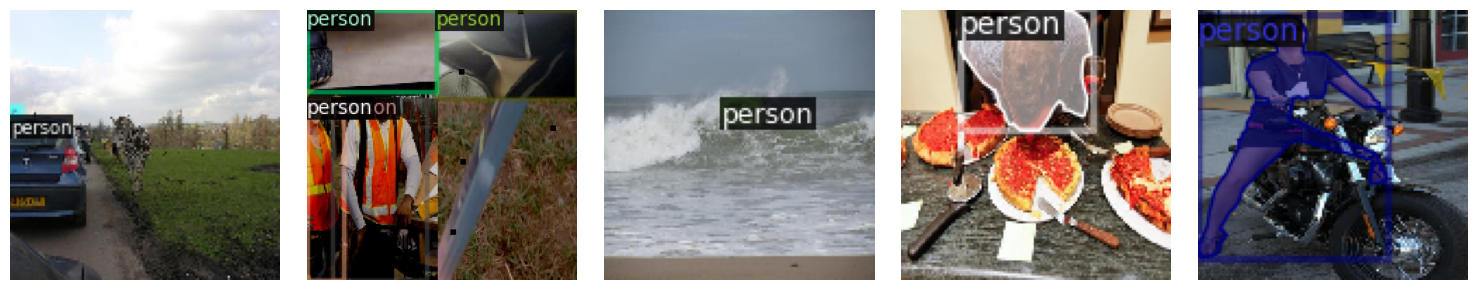

In [7]:
_ = visualize_ds(ds_train, ds_train_meta, n=5, cols=5)

### Val

KeyError: 'segmentation'

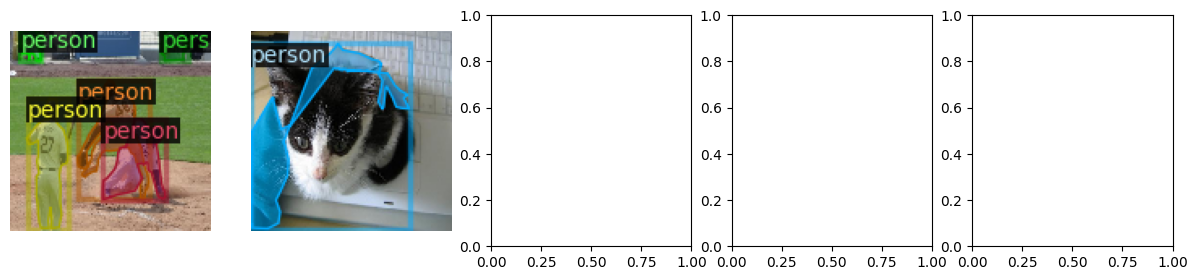

In [8]:
_ = visualize_ds(ds_val, ds_val_meta, n=5, cols=5)

### Test

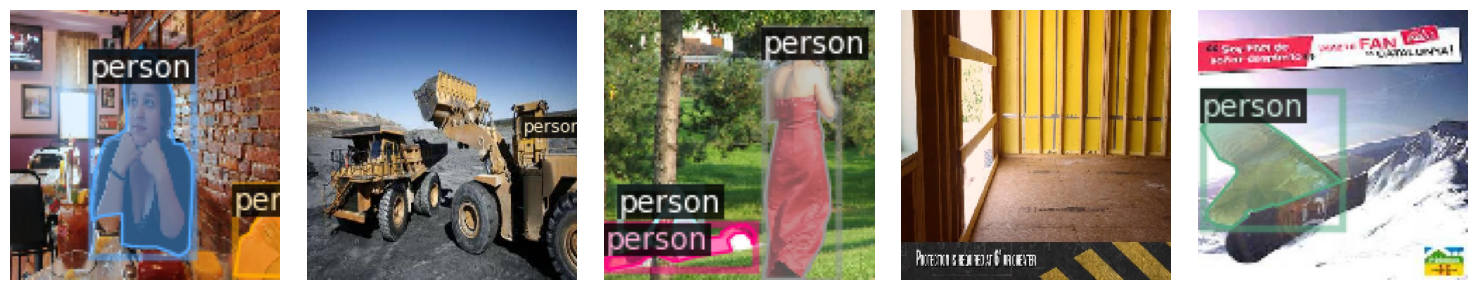

In [ ]:
_ = visualize_ds(ds_test, ds_test_meta, n=5, cols=5)


## Train

### Define configuration

In [9]:
def get_train_cfg(output_dir, config_file: str):
    return configure_cfg(
        len(CLASSES),
        [TRAIN_DS_DETECTRON_TAG],
        [TEST_DS_DETECTRON_TAG, VAL_DS_DETECTRON_TAG],
        config_file=config_file,
        output_dir=output_dir,
        epochs=20,
        eval_period_epochs=1,
        solver_steps=[5_000, 10_000],
    )

# config_file = "COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"
config_file = "COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"
output_dir = train_settings.output_dir / 'ppe_train' / train_settings.run_tag
# output_dir = "../logs/ppe_train/09apr-23_30_51_person_detection"
output_dir = '../logs/ppe_train/12apr-16_46_04_person_detection'
# output_dir = train_settings.output_dir / 'ppe_train' / '06apr-17_24_43'
logger.info(output_dir)
cfg = get_train_cfg(output_dir, config_file)
logger.info(cfg)

[ppe-modelling] 17.04.2025 02:33:15 ../logs/ppe_train/12apr-16_46_04_person_detection


[04/17 02:33:16 d2.data.datasets.coco]: Loaded 6326 images in COCO format from ../data/person_coco_instances/annotations/instances_train.json


[ppe-modelling] 17.04.2025 02:33:16 CUDNN_BENCHMARK: False
DATALOADER:
  ASPECT_RATIO_GROUPING: True
  FILTER_EMPTY_ANNOTATIONS: True
  NUM_WORKERS: 2
  REPEAT_SQRT: True
  REPEAT_THRESHOLD: 0.0
  SAMPLER_TRAIN: TrainingSampler
DATASETS:
  PRECOMPUTED_PROPOSAL_TOPK_TEST: 1000
  PRECOMPUTED_PROPOSAL_TOPK_TRAIN: 2000
  PROPOSAL_FILES_TEST: ()
  PROPOSAL_FILES_TRAIN: ()
  TEST: ['ds_test_person_detection', 'ds_val_person_detection']
  TRAIN: ['ds_train_person_detection']
FLOAT32_PRECISION: 
GLOBAL:
  HACK: 1.0
INPUT:
  CROP:
    ENABLED: False
    SIZE: [0.9, 0.9]
    TYPE: relative_range
  FORMAT: BGR
  MASK_FORMAT: polygon
  MAX_SIZE_TEST: 1333
  MAX_SIZE_TRAIN: 1333
  MIN_SIZE_TEST: 800
  MIN_SIZE_TRAIN: (640, 672, 704, 736, 768, 800)
  MIN_SIZE_TRAIN_SAMPLING: choice
  RANDOM_FLIP: horizontal
MODEL:
  ANCHOR_GENERATOR:
    ANGLES: [[-90, 0, 90]]
    ASPECT_RATIOS: [[0.5, 1.0, 2.0]]
    NAME: DefaultAnchorGenerator
    OFFSET: 0.0
    SIZES: [[32], [64], [128], [256], [512]]
  BACKBONE

### Define trainer

In [10]:
# self.trainer.storage.latest() - gives latest metrics...
# class TrainerBase:
#     def __init__(self) -> None:
#         self.storage: EventStorage
# However, no calls are being made that can be of mask-rcnn. That comes from model?

class CocoTrainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        if output_folder is None:
            output_folder = os.path.join(cfg.OUTPUT_DIR, "coco_evaluator_val")
        return COCOEvaluator(dataset_name, cfg, True, output_folder)

    def build_hooks(self):
        hooks = super().build_hooks()
        best_checkpoint_hook = BestCheckpointer(
            self.cfg.TEST.EVAL_PERIOD,
            checkpointer=self.checkpointer,
            val_metric="ds_val_person_detection/bbox/AP"
        )
        new_hooks = [best_checkpoint_hook]
        new_hooks = []
        hooks.extend(new_hooks)
        return hooks

trainer = CocoTrainer(cfg)
trainer.resume_or_load()

[04/17 02:33:17 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

### Run Train

In [11]:
results = trainer.train()
logger.info("\n" + pformat(results))

[04/17 02:33:20 d2.engine.train_loop]: Starting training from iteration 12640


/home/quakumei/.pyenv/versions/ppe-modelling/lib/python3.10/site-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[04/17 02:33:24 d2.engine.hooks]: Overall training speed: 1 iterations in 0:00:01 (1.3194 s / it)
[04/17 02:33:24 d2.engine.hooks]: Total training time: 0:00:01 (0:00:00 on hooks)
[04/17 02:33:24 d2.utils.events]:  eta: 0:47:52  iter: 12643  total_loss: 0.4636  loss_cls: 0.1182  loss_box_reg: 0.2328  loss_rpn_cls: 0.03503  loss_rpn_loc: 0.03688    time: 0.6888  last_time: 0.6888  data_time: 0.1163  last_data_time: 0.0887   lr: 1e-05  max_mem: 7069M


KeyboardInterrupt: 

In [ ]:
trainer.storage.latest()

{'rpn/num_pos_anchors': (13.25, 13251),
 'rpn/num_neg_anchors': (242.75, 13251),
 'roi_head/num_fg_samples': (37.0, 13251),
 'roi_head/num_bg_samples': (219.0, 13251),
 'fast_rcnn/cls_accuracy': (0.97998046875, 13251),
 'fast_rcnn/fg_cls_accuracy': (0.9054054054054054, 13251),
 'fast_rcnn/false_negative': (0.0945945945945946, 13251),
 'rank_data_time': (0.051577662998170126, 13251),
 'data_time': (0.051577662998170126, 13251),
 'total_loss': (0.2066655633971095, 13251),
 'loss_cls': (0.04811520874500275, 13251),
 'loss_box_reg': (0.13632827997207642, 13251),
 'loss_rpn_cls': (0.008523278869688511, 13251),
 'loss_rpn_loc': (0.013698795810341835, 13251),
 'lr': (1.0000000000000003e-05, 13251),
 'time': (0.5395953830011422, 13251),
 'eta_seconds': (2177.6518601192656, 13252),
 'ds_test_person_detection/bbox/AP': (48.0136233204069, 12639),
 'ds_test_person_detection/bbox/AP50': (75.76167034176294, 12639),
 'ds_test_person_detection/bbox/AP75': (50.969875130669394, 12639),
 'ds_test_person_

In [12]:
from torchinfo import summary

summary(trainer.model)

Layer (type:depth-idx)                                  Param #
GeneralizedRCNN                                         --
├─FPN: 1-1                                              --
│    └─Conv2d: 2-1                                      65,792
│    └─Conv2d: 2-2                                      590,080
│    └─Conv2d: 2-3                                      131,328
│    └─Conv2d: 2-4                                      590,080
│    └─Conv2d: 2-5                                      262,400
│    └─Conv2d: 2-6                                      590,080
│    └─Conv2d: 2-7                                      524,544
│    └─Conv2d: 2-8                                      590,080
│    └─LastLevelMaxPool: 2-9                            --
│    └─ResNet: 2-10                                     --
│    │    └─BasicStem: 3-1                              (9,408)
│    │    └─Sequential: 3-2                             (212,992)
│    │    └─Sequential: 3-3                             1,2

## Eval model

### Define predictor

In [13]:
print(len(CLASSES))

1


In [14]:
# output_dir = train_settings.output_dir / 'ppe_train' / '06apr-17_24_43'
# model_file = "model_0007899.pth"
model_file = "model_0012639.pth"
model_path = str(Path(output_dir) / model_file)
# config_file = "COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"

cfg = get_infer_cfg(str(model_path), config_file, len(CLASSES))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7
predictor = DefaultPredictor(cfg)

[04/17 02:33:50 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ../logs/ppe_train/12apr-16_46_04_person_detection/model_0012639.pth ...


### Infer Train

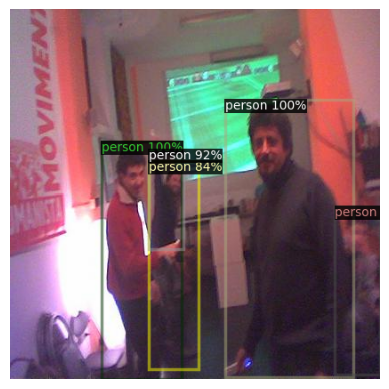

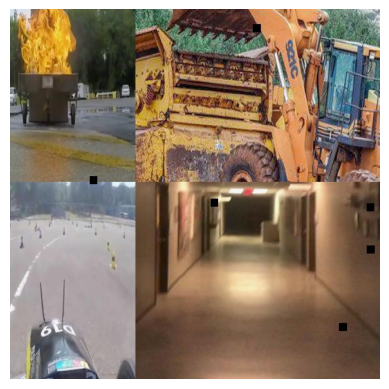

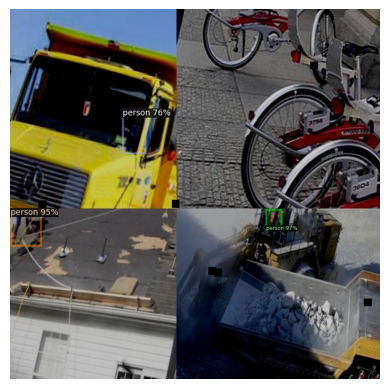

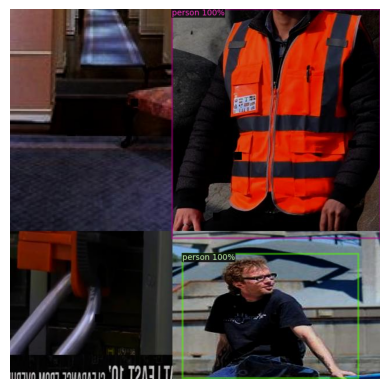

In [20]:
from detectron2.utils.visualizer import ColorMode
train_samples, train_predictions = infer_ds(predictor, ds_train, ds_train_meta, 4, ColorMode.IMAGE, 1)

### Infer Test

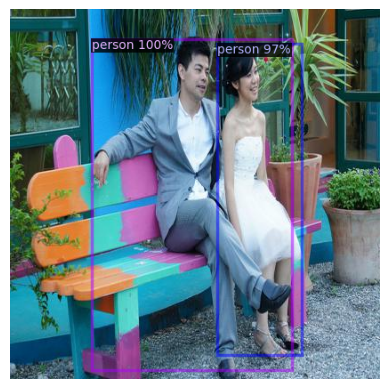

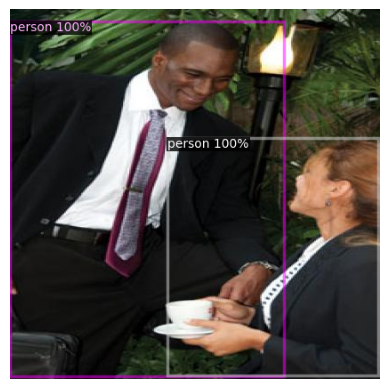

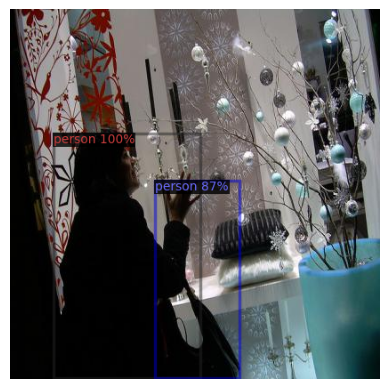

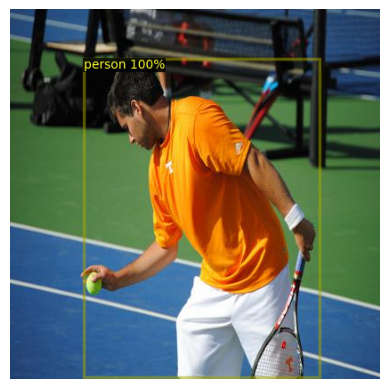

: 

In [ ]:
test_samples, test_predictions = infer_ds(predictor, ds_test, ds_test_meta, 4, ColorMode.IMAGE, 1)